In [152]:
%load_ext autoreload
%autoreload 2


import os

os.chdir("/Users/tenghu/Code/TrainingDynamics")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import uuid 
id = uuid.uuid4().hex
id

'3a2e1ac6981f498ba251132c1812d80b'

In [154]:
'''try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle'''
    
    
import pickle as pickle

    
import torchvision.transforms as transforms
from utils.mnist import IndexedMNIST as mnist

import matplotlib.pyplot as plt
import numpy as np
import pdb
import torch

import seaborn as sns
import time
import pandas as pd


from IPython.display import clear_output

In [204]:

import pickle5 as pickle

directories = [
    "control",
    "SB",
    "SB_upweighted",
    #"compaction",
    #"compaction70",
    ]


def load_blobs(files, blob_type="train"):
    start = time.time()
    blob_runs = []
    for count, file in enumerate(files):

        print ("Progress: {:0.2f} %, {} Seconds ".format((count + 1)/len(files) * 100, time.time() - start))
        clear_output(wait=True)
        with open(file + "/{}-log.txt.logger.blob.pickle".format(blob_type), 'rb') as handle:
            run = pickle.load(handle)
        blob_runs.append(run)
    return blob_runs


results = {}

for dname in directories:
    d =   dname
    dir_name = d + "_stats"
    files = [os.path.join(d, file)  for file in os.listdir(d) if "result" in file] #startswith("result-")][:5]
    results[dname] = {"train": load_blobs(files), "test":load_blobs(files, "test")}


Progress: 100.00 %, 6.198883056640625e-06 Seconds 


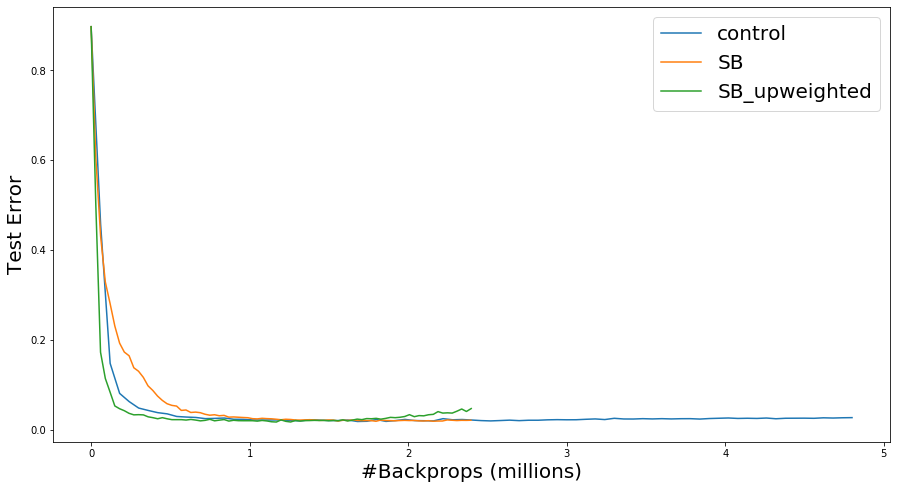

In [205]:
fig, ax = plt.subplots(figsize=(15, 8))

for dname in directories:
    num_backprops = np.cumsum([0] + results[dname]['train'][0]['epoch_backprops'])
    test_error = 1 - np.array(results[dname]['test'][0]['epoch_pred1'])
    plt.plot(num_backprops / 1e+6, test_error)

ax.set_xlabel("#Backprops (millions)", size=20)
ax.set_ylabel("Test Error", size=20)
plt.legend(directories,  fontsize=20)

#plt.legend(["Standard", "SB (beta=1)", "SB (beta=3)", "compaction, sample prob 0.1, confidence 0.8"],  fontsize=20)

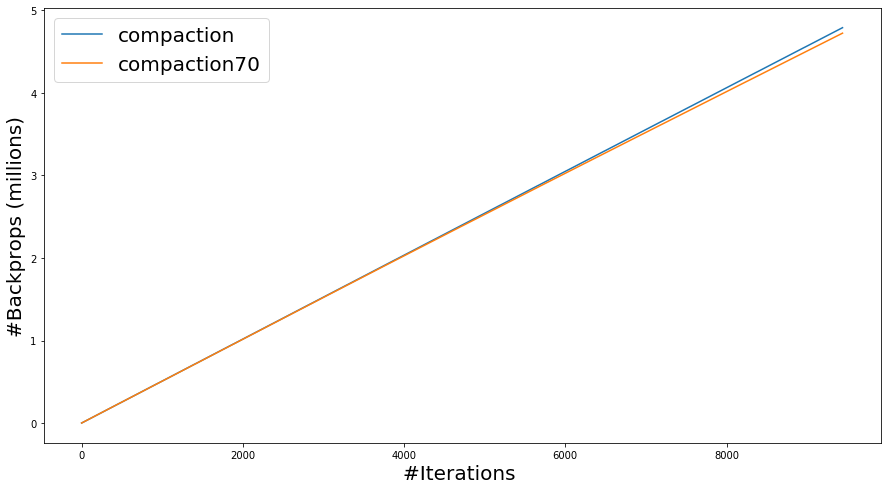

In [198]:
fig, ax = plt.subplots(figsize=(15, 8))

for dname in directories:
    plt.plot(np.cumsum(results[dname]['train'][0]['backprops']) / 1e+6)

ax.set_xlabel("#Iterations ", size=20)
ax.set_ylabel("#Backprops (millions)", size=20)
plt.legend(directories,  fontsize=20)
#plt.legend(["Standard", "SB (beta=1)", "SB (beta=3)", "compaction, sample prob 0.1, confidence 0.8"],  fontsize=20)

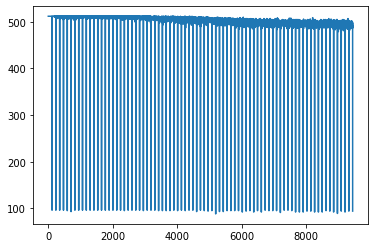

In [201]:
plt.plot(results['compaction70']['train'][0]['backprops'])

In [202]:
for dname in directories:
    num_backprops = np.cumsum(results[dname]['train'][0]['epoch_backprops'])
    test_acc = np.array(results[dname]['test'][0]['epoch_pred1'])
    print (dname, test_acc.max())

compaction 0.9812999998779297
compaction70 0.9816999998779297


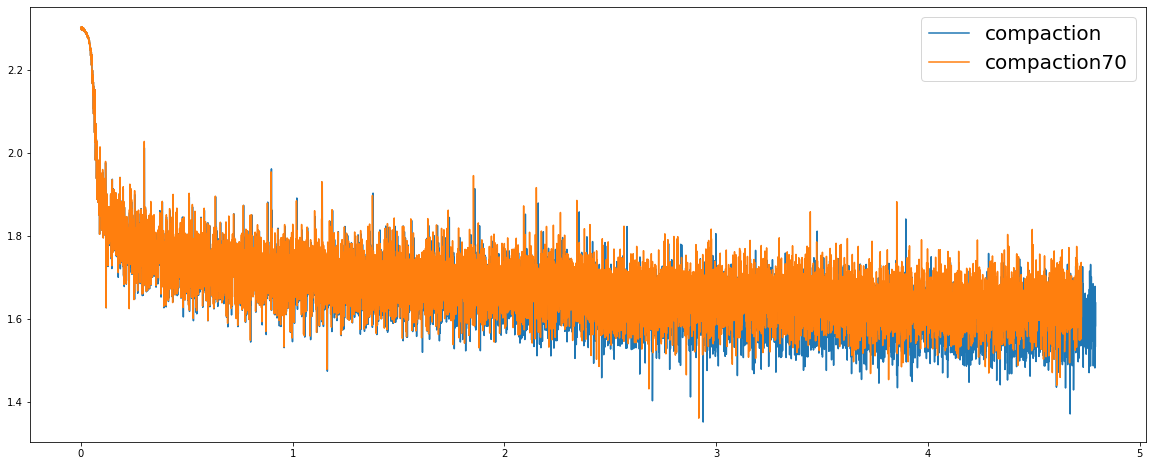

In [203]:
fig, ax = plt.subplots(figsize=(20, 8))

for dname in directories:
    num_backprops = np.cumsum(results[dname]['train'][0]['backprops'])
    plt.plot(num_backprops / 1e+6, results[dname]['train'][0]['train_loss'])


plt.legend(directories,  fontsize=20)

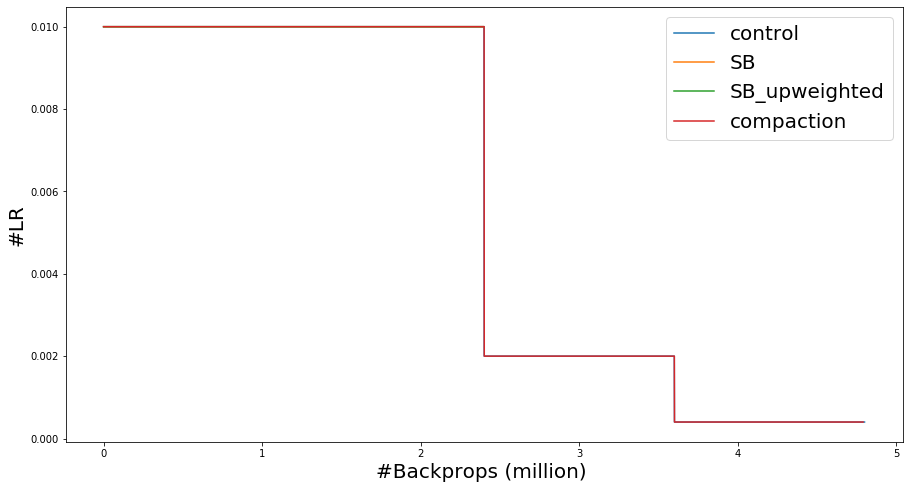

In [191]:
fig, ax = plt.subplots(figsize=(15, 8))

for dname in directories:
    plt.plot(np.cumsum(results[dname]['train'][0]['backprops']) / 1e+6, results[dname]['train'][0]['lr'])

ax.set_xlabel("#Backprops (million) ", size=20)
ax.set_ylabel("#LR", size=20)
plt.legend(directories,  fontsize=20)
#plt.legend(["Standard", "SB (beta=1)", "SB (beta=3)", "compaction, sample prob 0.1, confidence 0.8"],  fontsize=20)

# Generate Random Labels

In [86]:
def generate_random_labels(dataset, prob=0.5):
    ans = []
    classes = range(len(dataset.classes()))
    
    for j in dataset:
        if (np.random.random() < prob):
            ans += [np.random.choice(classes)]
        else:
            ans += [j[1]]
    return ans

In [103]:
from utils.cifar import IndexedCifar10
from utils.mnist import IndexedMNIST


trainset = IndexedMNIST(root='./data', train=True, download=True,transform=IndexedMNIST.transform_train)

In [145]:
ans = generate_random_labels(trainset, 0.5)

In [146]:
np.mean([j[1] == ans[j[2]] for j in trainset])

0.5499833333333334

In [147]:
np.save("dataset_overrides/50pct_random_label", ans)

In [151]:
40 * len(trainset)

2400000